[View in Colaboratory](https://colab.research.google.com/github/xsqian/github-names/blob/master/TGS_Kaggle.ipynb)

# DS Summit Oslo
## August 21 2018

## TGS Salt identification challenge hands-on

- One of the challenges of seismic imaging is to identify regions in subsurface that contain salt deposits. 
- A seismic image is produced from imaging the reflection coming from rock boundaries. 
- Segment salt deposits beneath the Earth's surface
- In machine learning - "Image salt segmentation problem" (https://www.kaggle.com/c/tgs-salt-identification-challenge)
- Supervised learning 
    - Training data consists of grayscale images (101 by 101 pixels) representing the sub-surface rock structure
    - Labeled data consists of images (101 by 101 pixels) marked as salt and no salt
- In addition to the seismic images, the depth of the imaged location is provided for each image. 
- The goal is to segment regions that contain salt.

# Strategy
- https://docs.google.com/document/d/1VWdRE_zN-FBGkvinL40DL515h5RXCIHyPKByUIqEAqs/edit?usp=sharing

- Model development
  - U-net
- Feature engineering
- Data augmentation
- Loss function selection
- Scoring metric
- Validation strategy
- Post processing techniques
  - Adjusting decision boundary
  - Test time augmentation
  - Apply CRF
  - Correct predictions using salt/no salt filter

In [1]:
!ls

sample_data


# Kaggle API setup

In [3]:
#Kaggle API
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pkjain","key":"8bef9d3ca34d65e083c703d71ecb355b"}'}

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 /root/.kaggle/kaggle.json

# Data retrieval

In [6]:
!kaggle competitions download -c tgs-salt-identification-challenge

  0%|                                                | 0.00/322k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 322k/322k [00:00<00:00, 63.4MB/s]
  0%|                                                | 0.00/264k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 264k/264k [00:00<00:00, 53.1MB/s]
  0%|                                                | 0.00/922k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 922k/922k [00:00<00:00, 117MB/s]
 99%|███████████████████████████████████████▍| 161M/163M [00:02<00:00, 79.7MB/s]
100%|████████████████████████████████████████| 163M/163M [00:02<00:00, 80.6MB/s]
 87%|█████████████████████████████████     | 33.0M/37.9M [00:00<00:00, 21.9MB/s]
100%|██████████████████████████████████████| 37.9M/37.9M [00:00<00:00, 53.4MB/s]


In [0]:
# Unzip data and moving to specific directories
if 1:
  !mkdir train
  !mkdir test
  !unzip -q train.zip
  !mv images masks train/
  !unzip -q test.zip
  !mv images test/

# Import Python libraries

In [8]:
from numpy.random import seed
from tensorflow import set_random_seed

import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize
from keras.models import load_model


Using TensorFlow backend.


In [0]:
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, Dropout, BatchNormalization, UpSampling2D


#try:
#  from tqdm import tqdm_notebook
#  from tqdm import trange
#except:
#  !pip3 install tqdm
#  from tqdm import tqdm_notebook

# Params and helpers

In [0]:
img_size_ori = 101 #Input image size dimenstion 101 by 101
img_size_target = 128 #Scale the image to 128 by 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

# Read input data

## Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Also create a test DataFrame with entries from depth not in train.

In [0]:
train_df = pd.read_csv("train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

## Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [0]:
train_df["images"] = [np.array(load_img("train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in train_df.index]

# Every image is of size 101x101

In [0]:
train_df["masks"] = [np.array(load_img("train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in train_df.index]

# Data exploration

## Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only.
Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [0]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [0]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0,0.5,'Coverage class')

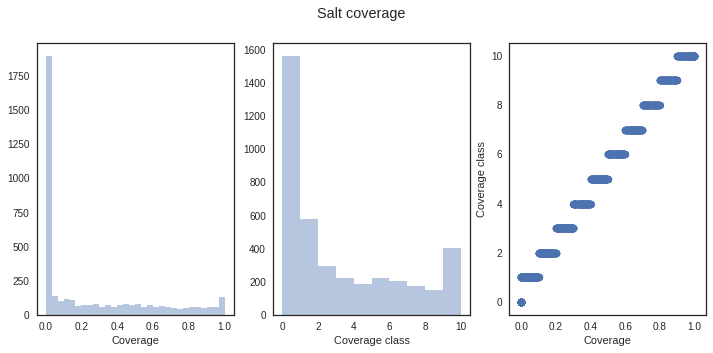

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0], bins=30)
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")
axs[2].set_xlabel('Coverage')
axs[2].set_ylabel('Coverage class')

## Plotting the depth distributions
Separatelty plotting the depth distributions for the training and the testing data.

Text(0.5,1,'Depth distribution')

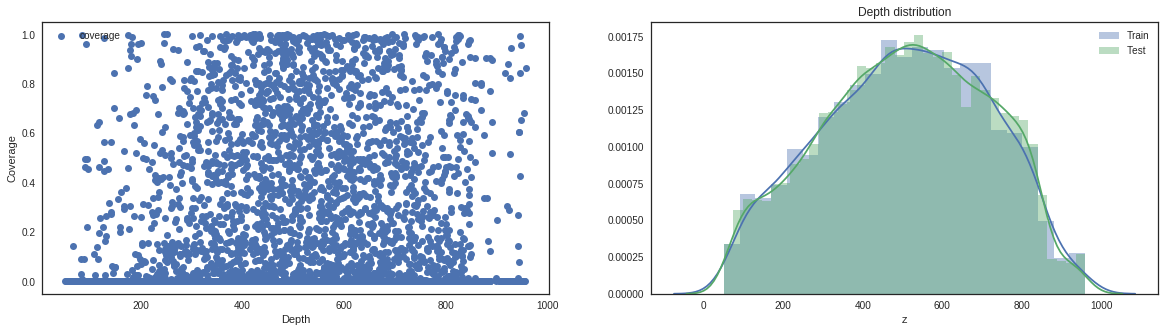

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20,5))
train_df.plot('z','coverage',style='o', ax=axs[0])
axs[0].set_xlabel('Depth')
axs[0].set_ylabel('Coverage')
ax = sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test", ax=ax)

plt.legend()
plt.title("Depth distribution")

## Show some example images

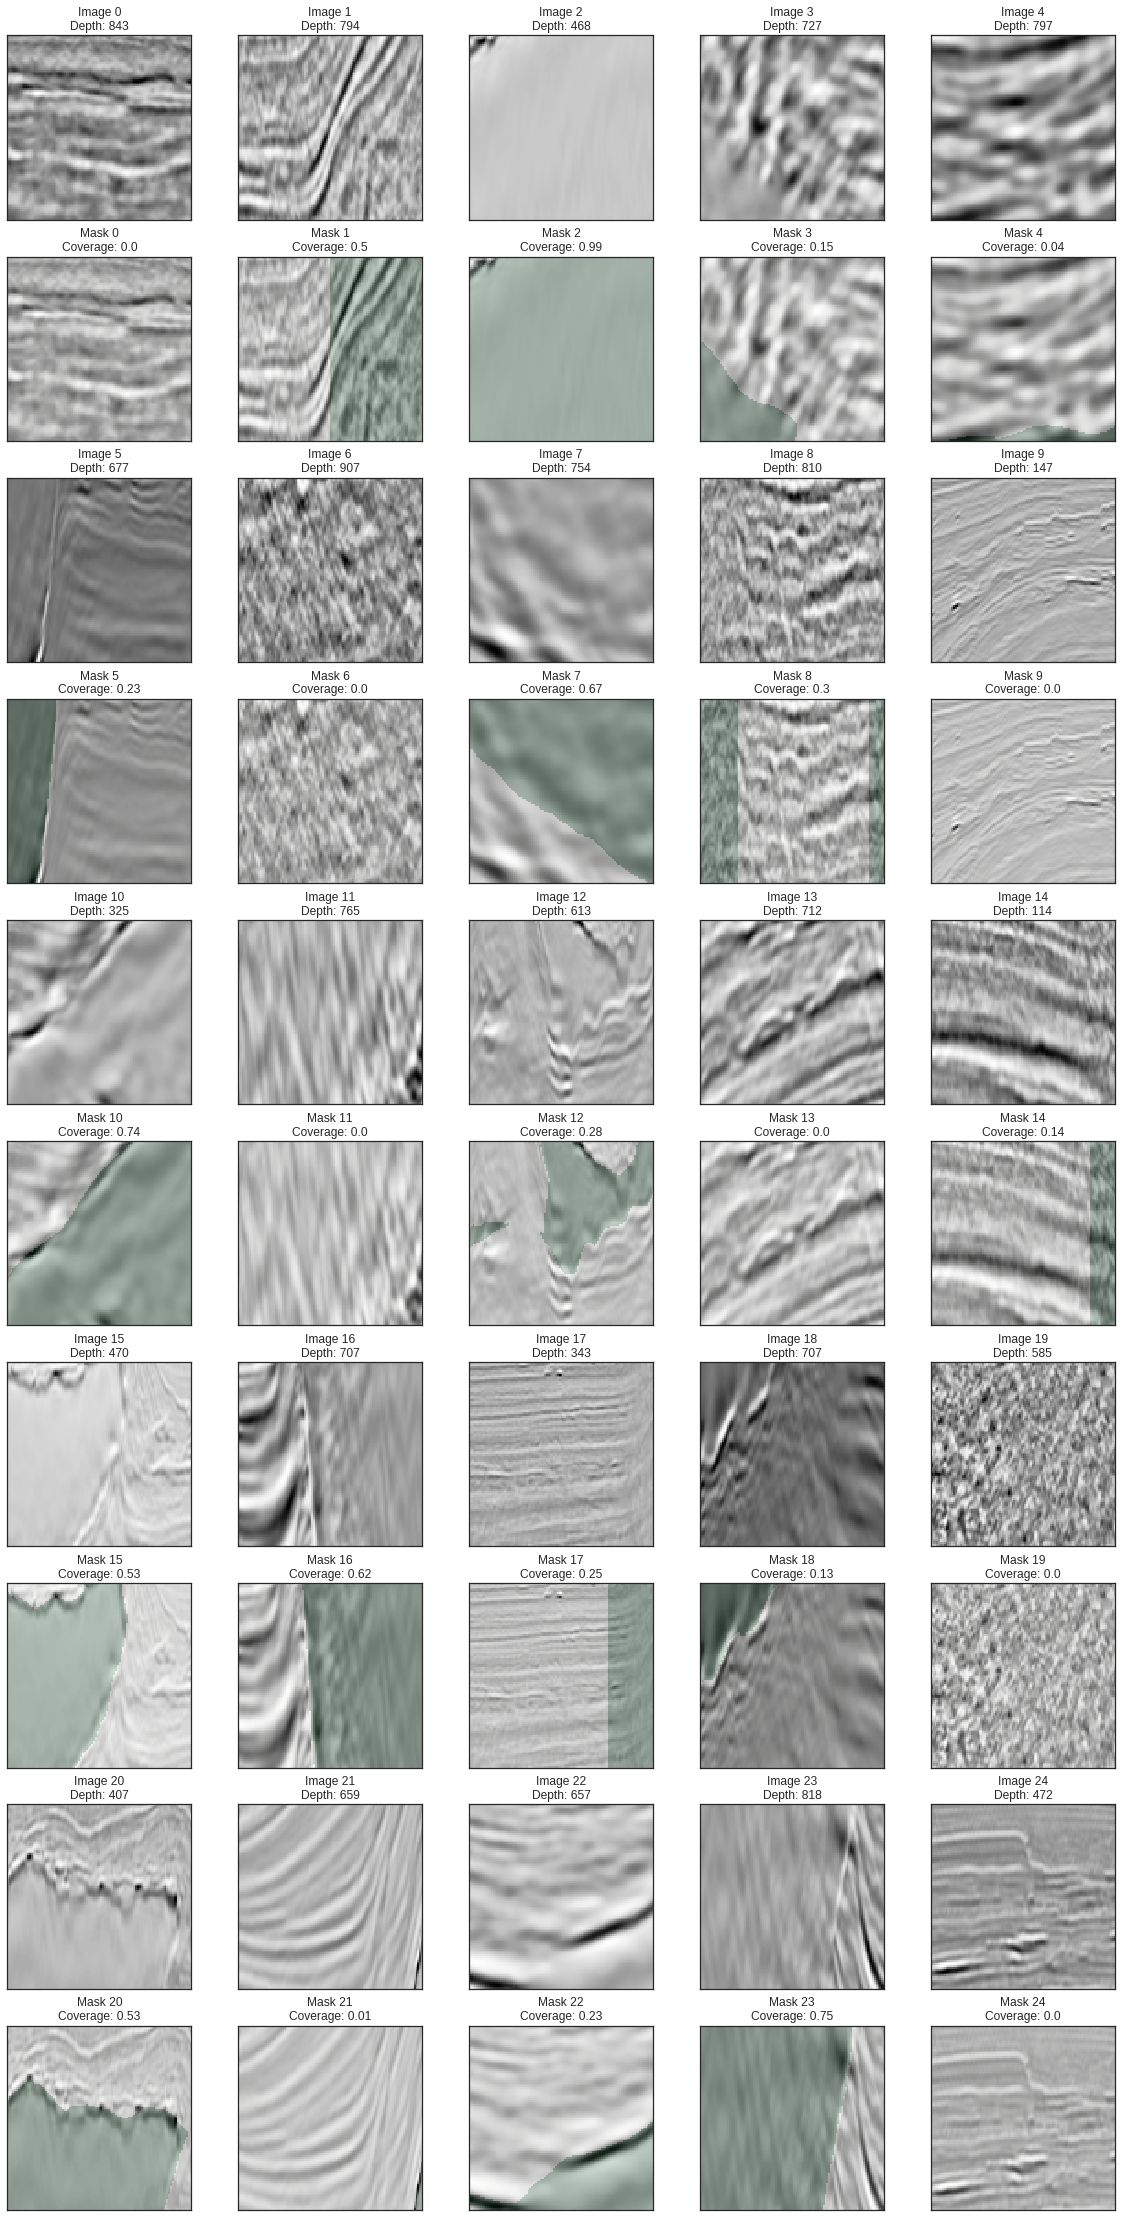

In [18]:
max_images = 25
grid_width = 5
grid_height = int(max_images / grid_width)*2
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax_image = axs[int(i / grid_width)*2, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image {0}\nDepth: {1}".format(i, train_df.loc[idx].z))
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*2+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.2, cmap="Greens")
    ax_mask.set_title("Mask {0}\nCoverage: {1}".format(i,  round(train_df.loc[idx].coverage, 2)))
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])

# Feature generation
- Perform image processing on inpiut images (for instance, increase contrast) and generate new features
- Add new features as additional channel to the input

In [64]:
#Facility to add channels in input

from skimage import exposure
from skimage.feature import canny


im_height = 128
im_width = 128
im_chan = 1 # Number of channels
n_features = 1 #Number of extra features like depth
path_train = './train'
border = 5

# Get and resize train images and masks
X = np.zeros((len(train_df), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_df), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_df), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
for n, id_ in enumerate(train_df.index):
    path = path_train
    
    # Depth
    #X_feat[n] = depths_df.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_ + '.png', grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    if 0:
      x_center_mean = x_img[border:-border, border:-border].mean()
      x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
      x_csum -= x_csum[border:-border, border:-border].mean()
      x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())
    
    # Increase exposure
    if 0:
      x_equalize_hist = exposure.equalize_hist(x_img)
      #x_adaptive_equalize_hist = exposure.equalize_adapthist(x_img)
      #x_canny = canny(x_img[:,:,0])
      # Contrast stretching
      p2, p98 = np.percentile(img, (2, 98))
      x_contrast = exposure.rescale_intensity(x_img, in_range=(p2, p98))

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_ + '.png', grayscale=True))
    mask = resize(mask, (im_height, im_width, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    if 0:
      X[n, ..., 1] = x_csum.squeeze()
    if 0:
      X[n,...,1] = x_equalize_hist.squeeze()
      #X[n,...,2] = x_adaptive_equalize_hist.squeeze()/255
      #X[n,...,2] = x_canny.squeeze()/255
      X[n,...,2] = x_contrast.squeeze()
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 
Done!


## Example of feature engineering

IndexError: ignored

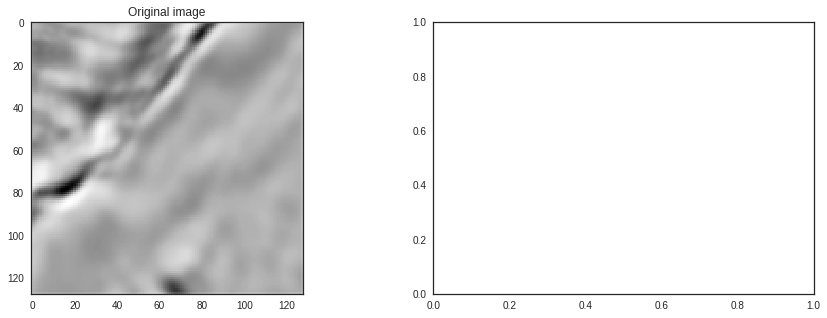

In [55]:
#checking feature engineering
if 1:
  #tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.iloc[10].dtype)
  #tmp_img[:img_size_ori, :img_size_ori] = train_df.images.iloc[10]
  fix, axs = plt.subplots(1, 2, figsize=(15,5))
  axs[0].imshow(X[10,...,0].squeeze(), cmap="Greys")
  axs[0].set_title("Original image")
  axs[1].imshow(X[10,...,1].squeeze(), cmap="Greys")
  axs[1].set_title("Scaled image")

# Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [0]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.index.values,
    X, 
    y, 
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

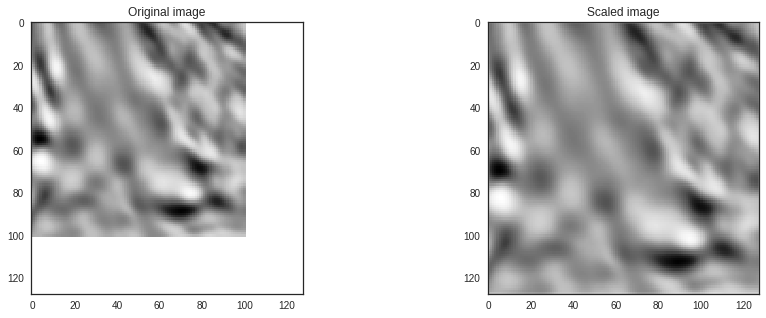

In [66]:
# Checking resizing
if 1:
  tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
  tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
  fix, axs = plt.subplots(1, 2, figsize=(15,5))
  axs[0].imshow(tmp_img, cmap="Greys")
  axs[0].set_title("Original image")
  axs[1].imshow(x_train[10,...,0].squeeze(), cmap="Greys")
  axs[1].set_title("Scaled image")

# Build model
 - U-net: https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/
 ![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

## Define loss

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

## Define model

In [0]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.25)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.25)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.25)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.25)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.25)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    uncov1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

In [0]:
from keras.layers.normalization import BatchNormalization
from keras import regularizers


def build_model_stanford(input_layer, start_neurons, activation="relu", reg=False):
  
    "http://cs230.stanford.edu/files_winter_2018/projects/6937642.pdf"
    # 128 -> 64
    
    axis = -1
    
    if reg:
      conv1 = Conv2D(start_neurons * 1, (3, 3), activation=activation, padding="same", kernel_regularizer=regularizers.l2(0.01))(input_layer)
    else:
      conv1 = Conv2D(start_neurons * 1, (3, 3), activation=activation, padding="same")(input_layer)
    conv1 = BatchNormalization(axis=axis)(conv1)
    if reg:
      conv1 = Conv2D(start_neurons * 1, (3, 3), activation=activation, padding="same", kernel_regularizer=regularizers.l2(0.01))(conv1)
    else:
      conv1 = Conv2D(start_neurons * 1, (3, 3), activation=activation, padding="same")(conv1)
    conv1 = BatchNormalization(axis=axis)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    if reg:
      conv2 = Conv2D(start_neurons * 2, (3, 3), activation=activation, padding="same", kernel_regularizer=regularizers.l2(0.01))(pool1)
    else:
      conv2 = Conv2D(start_neurons * 2, (3, 3), activation=activation, padding="same")(pool1)
    conv2 = BatchNormalization(axis=axis)(conv2)
    if reg:
      conv2 = Conv2D(start_neurons * 2, (3, 3), activation=activation, padding="same", kernel_regularizer=regularizers.l2(0.01))(conv2)
    else:
      conv2 = Conv2D(start_neurons * 2, (3, 3), activation=activation, padding="same")(conv2)
    conv2 = BatchNormalization(axis=axis)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #pool2 = Dropout(0.25)(pool2)

    # 32 -> 16
    if reg:
      conv3 = Conv2D(start_neurons * 4, (3, 3), activation=activation, padding="same", kernel_regularizer=regularizers.l2(0.01))(pool2)
    else:
      conv3 = Conv2D(start_neurons * 4, (3, 3), activation=activation, padding="same")(pool2)
    conv3 = BatchNormalization(axis=axis)(conv3)
    if reg:
      conv3 = Conv2D(start_neurons * 4, (3, 3), activation=activation, padding="same", kernel_regularizer=regularizers.l2(0.01))(conv3)
    else:
      conv3 = Conv2D(start_neurons * 4, (3, 3), activation=activation, padding="same")(conv3)
    conv3 = BatchNormalization(axis=axis)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    #pool3 = Dropout(0.25)(pool3)

    # 16 -> 8
    if reg:
      conv4 = Conv2D(start_neurons * 8, (3, 3), activation=activation, padding="same", kernel_regularizer=regularizers.l2(0.01))(pool3)
    else:
      conv4 = Conv2D(start_neurons * 8, (3, 3), activation=activation, padding="same")(pool3)
    conv4 = BatchNormalization(axis=axis)(conv4)
    if reg:
      conv4 = Conv2D(start_neurons * 8, (3, 3), activation=activation, padding="same", kernel_regularizer=regularizers.l2(0.01))(conv4)
    else:
      conv4 = Conv2D(start_neurons * 8, (3, 3), activation=activation, padding="same")(conv4)
    conv4 = BatchNormalization(axis=axis)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    #pool4 = Dropout(0.25)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation=activation, padding="same")(pool4)
    convm = BatchNormalization(axis=axis)(convm)
    convm = Conv2D(start_neurons * 16, (3, 3), activation=activation, padding="same")(convm)
    convm = BatchNormalization(axis=axis)(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.25)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=activation, padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=activation, padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.25)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=activation, padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=activation, padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=activation, padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=activation, padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=activation, padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=activation, padding="same")(uconv1)

    uncov1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, im_chan))
output_layer = build_model_stanford(input_layer, 16)

In [0]:
def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = Dropout(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m

def UNet_dingli(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

model = UNet_dingli((img_size_target,img_size_target,im_chan),start_ch=16,depth=5,batchnorm=True)


In [0]:
# Download an external metrics file (from a journal paper)
if 0:
    from google.colab import files
    src = list(files.upload().values())[0]
    open('metrics.py','wb').write(src)
    import metrics

Saving metrics.py to metrics.py


Using TensorFlow backend.


In [0]:
model = Model(input_layer, output_layer)

In [0]:
model.compile(optimizer="adam", metrics=["accuracy"], loss='binary_crossentropy')

In [70]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 16) 160         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_45 (BatchNo (None, 128, 128, 16) 64          conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 16) 2320        batch_normalization_45[0][0]     
__________________________________________________________________________________________________
batch_norm

# Data augmentation

In [0]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [72]:
# Remove unnecessary variables from memory
import gc
del flipped, flipped_mask
gc.collect()

NameError: ignored

Text(0.5,0.98,'Top row: original images, bottom row: augmented images')

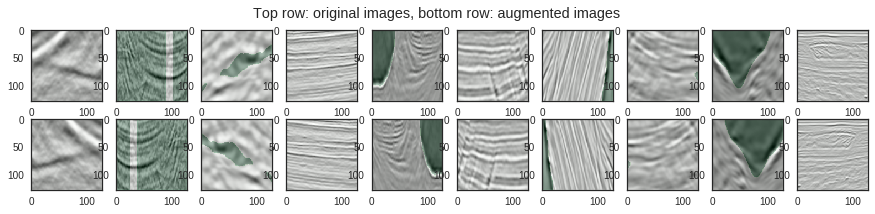

In [73]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i,...,0].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i,...,0].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i),...,0].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i),...,0].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

# Training

In [74]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.BN_RELU_batch_64_cleaned", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 64

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr], shuffle=True)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - 67s 11ms/step - loss: 0.4270 - acc: 0.8365 - val_loss: 1.1927 - val_acc: 0.7979

Epoch 00001: val_loss improved from inf to 1.19270, saving model to ./keras.BN_RELU_batch_64_cleaned
Epoch 2/200
6400/6400 [==============================] - 59s 9ms/step - loss: 0.3097 - acc: 0.8793 - val_loss: 0.5210 - val_acc: 0.8657

Epoch 00002: val_loss improved from 1.19270 to 0.52098, saving model to ./keras.BN_RELU_batch_64_cleaned
Epoch 3/200
6400/6400 [==============================] - 59s 9ms/step - loss: 0.2510 - acc: 0.9003 - val_loss: 0.5112 - val_acc: 0.8444

Epoch 00003: val_loss improved from 0.52098 to 0.51125, saving model to ./keras.BN_RELU_batch_64_cleaned
Epoch 4/200
6400/6400 [==============================] - 59s 9ms/step - loss: 0.2203 - acc: 0.9087 - val_loss: 0.3177 - val_acc: 0.8887

Epoch 00004: val_loss improved from 0.51125 to 0.31775, saving model to ./keras.BN_RELU_batch

## Plot model loss

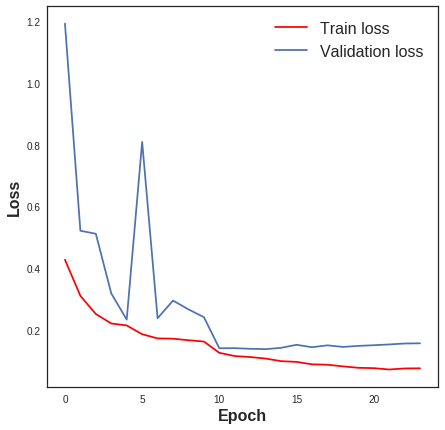

In [75]:
fig, ax_loss = plt.subplots(1, 1, figsize=(7,7))
ax_loss.plot(history.epoch, history.history["loss"], 'r', label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.set_xlabel('Epoch', fontsize=16, fontweight='bold')
ax_loss.set_ylabel('Loss', fontsize=16, fontweight='bold')
plt.legend(fontsize=16)
#ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
#ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

In [0]:
#If the model is already trained. Can load it here.
if 0:
    model = load_model("./keras.BN_RELU_batch_64_cleaned")

In [76]:
# Facility to download model file
if 1:
    from google.colab import files
    files.download("./keras.BN_RELU_batch_64_cleaned")

KeyboardInterrupt: ignored

## Predict the validation set to do a sanity check


In [0]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid = np.array([downsample(x) for x in y_valid])

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

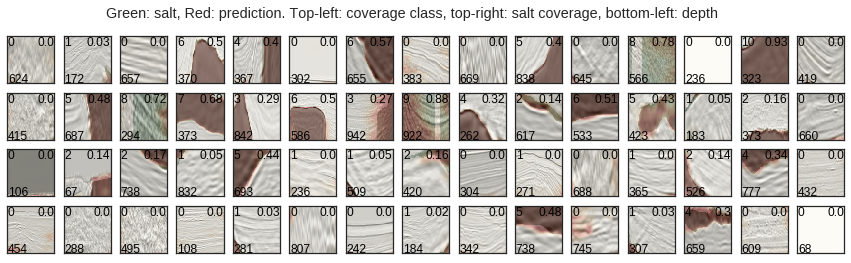

In [78]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Scoring - Intersection over union


In [0]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

# Post-processing techniques
Here we will see 4 techniques that can boost the performance of the model.
- Adjusting decision threshold
- Test time augmentation
- Applying CRF
- Applying Salt/No salt filter

## Adjusting the decision threshold

In [0]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid, np.int32(preds_valid > threshold)) for threshold in thresholds])

threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

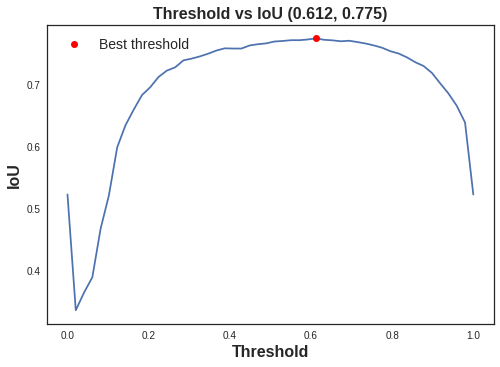

In [82]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "ro", label="Best threshold")
plt.xlabel("Threshold", fontsize=16, fontweight='bold')
plt.ylabel("IoU", fontsize=16, fontweight='bold')
plt.title("Threshold vs IoU ({:.3f}, {:.3f})".format(threshold_best, iou_best), fontsize=16, fontweight='bold')
plt.legend(fontsize=14)

### Another sanity check with adjusted threshold
Again some sample images with the adjusted threshold.

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

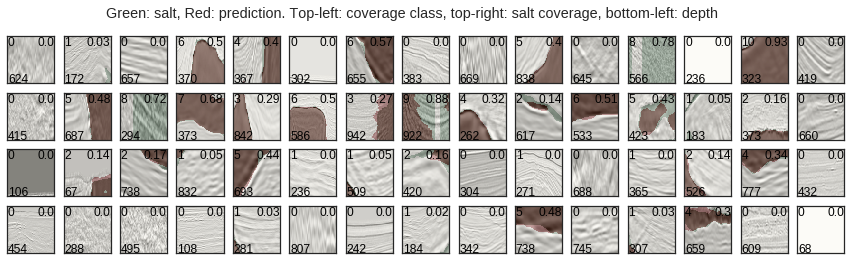

In [83]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

## Test time augmentation
- Allowing model to find information in  flipped images as well
- Methodology
    - Prediction 1: test data -> Model -> Prediction 1
    - Prediction 2: test_data -> flip test data -> Model predict -> flip prediction -> Prediction 2
      - New prediction = 0.5* (Prediction 1 + Prediction 2)
      - New prediction = max(Prediction 1, Prediction 2)

In [0]:
#x_valid_flipped = np.fliplr(x_valid)
#x_valid_flipped = [np.fliplr(x) for x in x_valid]
#A = [np.fliplr(x) for x in x_valid]
#x_valid_flipped = np.array([x for x in A])
x_valid_flipped = np.array([np.fliplr(x) for x in x_valid])

preds_valid_flipped = model.predict(x_valid_flipped).reshape(-1, img_size_target, img_size_target)
preds_valid_flipped = np.array([downsample(x) for x in preds_valid_flipped])
#new_preds_valid = np.fliplr(preds_valid_flipped)
new_preds_valid = [np.fliplr(x) for x in preds_valid_flipped]

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

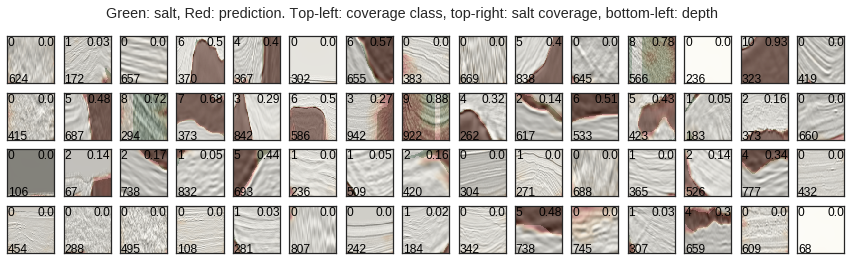

In [142]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = new_preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [0]:
updated_preds_valid = 0.5*(new_preds_valid + preds_valid)

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

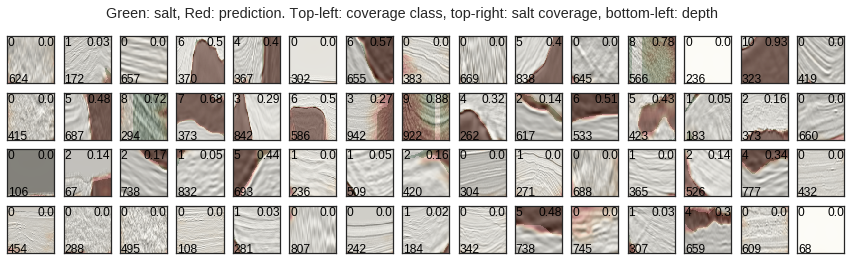

In [144]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = updated_preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

Text(0.5,0.98,'Top row: original images, bottom row: augmented images')

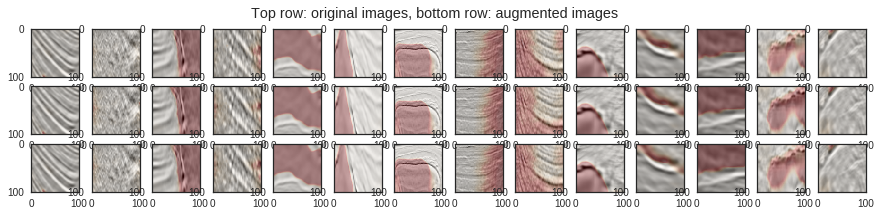

In [145]:
fig, axs = plt.subplots(3, 14, figsize=(15,3))
offset=14
for i in range(14):
    axs[0][i].imshow(x_valid[i+offset,:,:,0].squeeze(), cmap="Greys")
    axs[0][i].imshow(preds_valid[i+offset].squeeze(), cmap="OrRd", alpha=0.3)    
    axs[1][i].imshow(x_valid[i+offset,:,:,0].squeeze(), cmap="Greys")
    axs[1][i].imshow(new_preds_valid[i+offset].squeeze(), cmap="OrRd", alpha=0.3)
    axs[2][i].imshow(x_valid[i+offset,:,:,0].squeeze(), cmap="Greys")
    axs[2][i].imshow(updated_preds_valid[i+offset].squeeze(), cmap="OrRd", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

### Plot updated ious

In [0]:
thresholds = np.linspace(0, 1, 50)
updated_ious = np.array([iou_metric_batch(y_valid, np.int32(updated_preds_valid > threshold)) for threshold in thresholds])

updated_threshold_best_index = np.argmax(updated_ious[9:-10]) + 9
updated_iou_best = updated_ious[updated_threshold_best_index]
updated_threshold_best = thresholds[updated_threshold_best_index]

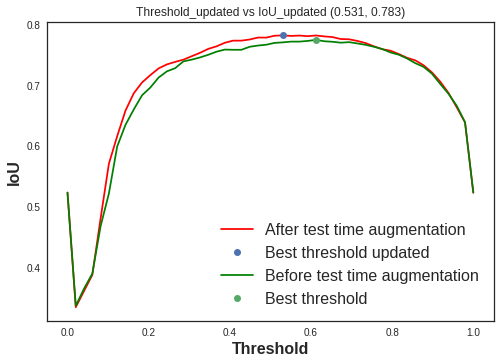

In [147]:
plt.plot(thresholds, updated_ious,'r', label='After test time augmentation')
plt.plot(updated_threshold_best, updated_iou_best, "o", label="Best threshold updated")
plt.plot(thresholds, ious, 'g', label='Before test time augmentation')
plt.plot(threshold_best, iou_best, "o", label="Best threshold")
plt.xlabel("Threshold", fontsize=16, fontweight='bold')
plt.ylabel("IoU", fontsize=16, fontweight='bold')
plt.title("Threshold_updated vs IoU_updated ({:,.3f}, {:,.3f})".format(updated_threshold_best, updated_iou_best))
plt.legend(loc='best', fontsize=16)

### Another sanity check with adjusted threshold
Again some sample images with the adjusted threshold.

Text(0.5,0.98,'UPDATED Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

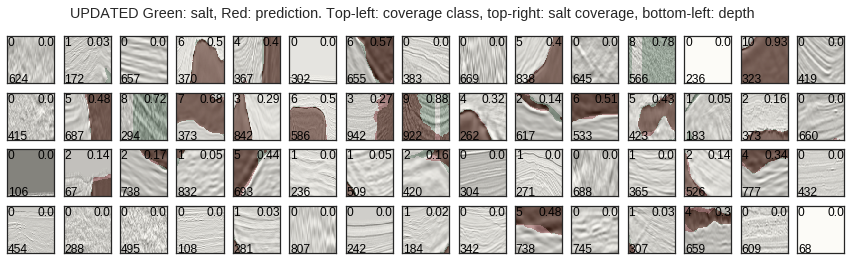

In [148]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = updated_preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > updated_threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("UPDATED Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

## Apply CRF
- Probabilistic models for images
- Taps into pixel neighborhood statistics
- https://www.youtube.com/watch?v=rc3YDj5GiVM
- http://vision.stanford.edu/teaching/cs231b_spring1213/slides/segmentation.pdf


In [149]:
try:
  import pydensecrf.densecrf as dcrf
except:
  !pip3 install pydensecrf
  import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave, imshow
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray

    100% |████████████████████████████████| 1.0MB 16.9MB/s 
  Running setup.py bdist_wheel for pydensecrf ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/92/6f/ec/5c49c25de8c42c872de50ff53582ba3ead850ce52a81e73ac7
Successfully built pydensecrf


In [0]:
def rle_decode(rle_mask):
    '''
    rle_mask: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(101*101, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(101,101)

"""
used for converting the decoded image to rle mask

"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [0]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [0]:
pred_dict = {idx: RLenc(np.round(downsample(updated_preds_valid[i]) > updated_threshold_best)) for i, idx in enumerate(ids_valid)}

In [0]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('saved_valid_predictions_additional_channel.csv')

In [0]:
if 1:
    from google.colab import files
    files.download('saved_valid_predictions_additional_channel.csv')

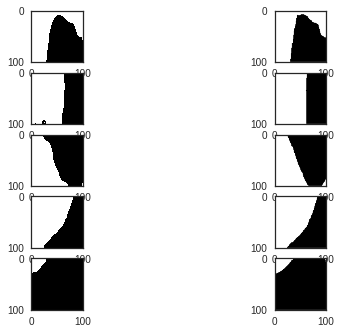

In [156]:
"""
reading and decoding the submission 

"""

df = pd.read_csv('saved_valid_predictions_additional_channel.csv')
i = 0
j = 0
plt.figure(figsize=(20,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
fig,ax = plt.subplots(5,2)
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])
        #plt.subplot(1,6,j+1)
        ax[j,0].imshow(np.flipud(np.rot90(decoded_mask)))
        ax[j,1].imshow(y_valid[i,:,:,0])
        #plt.title('ID: '+df.loc[i,'id'])
        j = j + 1
        if j>4:
            break
    i = i + 1

In [0]:
"""
Function which returns the labelled image after applying CRF

"""
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)
    
    #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
    # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

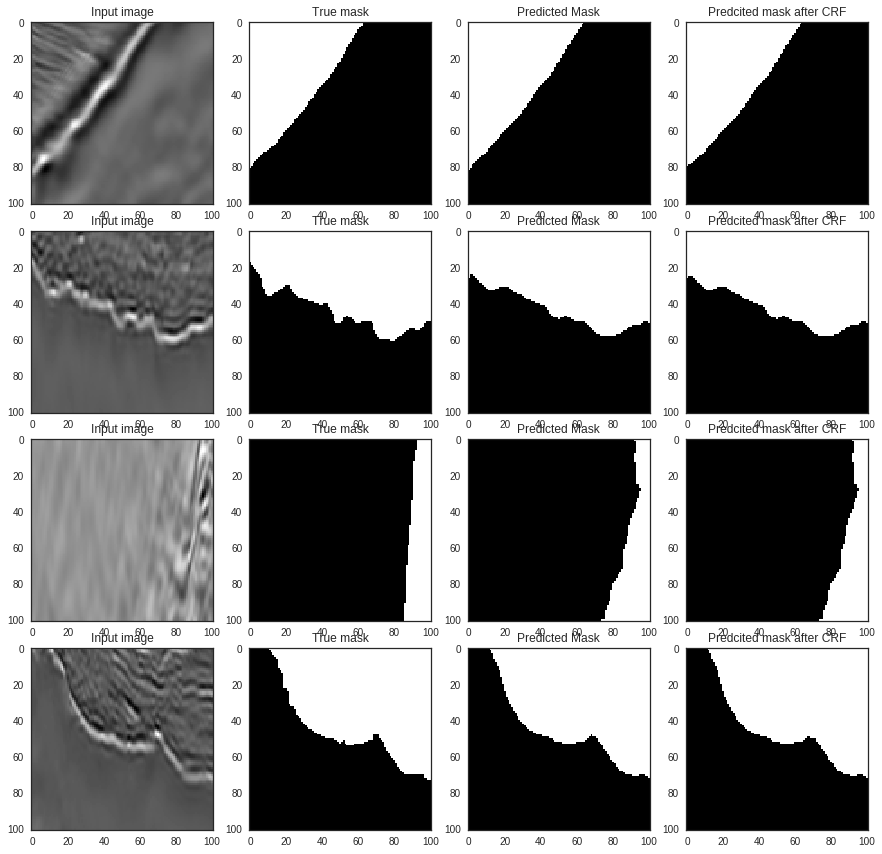

In [158]:
"""
visualizing the effect of applying CRF

"""
train_path = "./train/masks/"
nImgs = 4
i = np.random.randint(800)
j = 1
plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.2,hspace=0.1)  #adjust this to change vertical and horiz. spacings..
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])    
        
        orig_img = imread("./train/images/"+df.loc[i,'id']+'.png')
        crf_output = crf(orig_img,decoded_mask)
        plt.subplot(nImgs,4,4*j-3)
        plt.imshow(orig_img)
        plt.title('Input image')
        
        orig_img = imread(train_path+df.loc[i,'id']+'.png')
        crf_output = crf(orig_img,decoded_mask)
        plt.subplot(nImgs,4,4*j-2)
        plt.imshow(orig_img)
        plt.title('True mask')
        plt.subplot(nImgs,4,4*j-1)
        #plt.imshow(decoded_mask) 
        plt.imshow(np.fliplr(np.rot90(decoded_mask,k=3)))

        plt.title('Predicted Mask')
        plt.subplot(nImgs,4,4*j)
        #plt.imshow(crf_output) 
        plt.imshow(np.fliplr(np.rot90(crf_output,k=3)))
        plt.title('Predcited mask after CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    i = i + 1

In [0]:
"""
Applying CRF on the predicted mask 

"""
decoded_mask_array = []
crf_output_array = []
for i in range(df.shape[0]):
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])  
        decoded_mask_array.append(decoded_mask)
        orig_img = imread(train_path+df.loc[i,'id']+'.png')        
        crf_output = crf(orig_img,decoded_mask)
        crf_output_array.append(crf(orig_img,decoded_mask))
        df.loc[i,'rle_mask'] = rle_encode(crf_output)
    else:
        decoded_mask_array.append(np.zeros((101,101)))
        crf_output_array.append(np.zeros((101,101)))
crf_output_array = np.expand_dims(crf_output_array, axis=3)

In [0]:
df.to_csv('crf_correction_unet.csv',index=False)

In [161]:
tranformed_crf_output_array = np.array([np.fliplr(np.rot90(x,k=3)) for x in crf_output_array])
crf_iou = iou_metric_batch(y_valid, tranformed_crf_output_array)
print("IoU after CRF = {}".format(crf_iou))


IoU after CRF = 0.7916249999999999


In [0]:
masked_cells_predicted = np.array([x.sum()/(101.0*101.0) for x in crf_output_array])
masked_cells_true = np.array([x.sum()/(101.0*101.0) for x in y_valid])

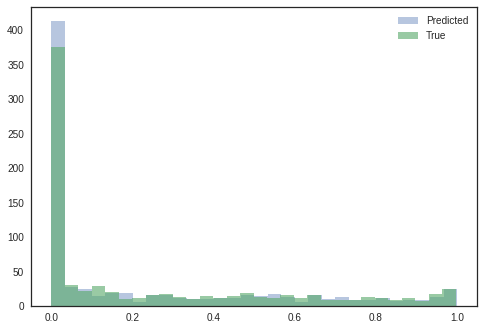

In [163]:
plt.hist(masked_cells_predicted[masked_cells_predicted >= 0.0], bins=30, alpha=0.4, label='Predicted')
plt.hist(masked_cells_true[masked_cells_true >= 0.0], bins=30, alpha=0.6, label='True')
plt.legend()

In [0]:
if 1:
    from google.colab import files
    files.download('crf_correction_unet.csv')

## Salt no salt filter
- Heavy penalization for false positives (predict salt when it does not exist)
- Use a separate model that predicts salt exists or not in the given image
  - Imagine this to be an extra validation or an additional filter on your final prediction
  - In practice, this means we are being conservative/safer in our final prediction
- This model is currently created using transfer learning (Resnet)

In [0]:
# Import model from a different Colab book...

# Load the model...

# Salt_NoSalt_prediction = Predict whether the images have salt or not...

# Correct our Unet prediction based on Salt_NoSalt_prediction...

# Summary

https://drive.google.com/file/d/1lrL9KsRto_ObZgiR7kpBOw581jprfmsq/view?usp=sharing

# Final remarks
- In theory, you want to ultimately build an ensemble of outputs from very uncorrelated models. So using a variety of techniques is probably a good idea.
- Do not overfit to the public leaderboard!!!
In theory, ignoring the leaderboard and relying on your own (rigorous and robust) local validation scores is better
- Google Colab vs Kaggle kernel
- Good team bulding exercise
- Fun


# Submission
Load, predict and submit the test image predictions.

In [0]:
x_test = np.array([upsample(np.array(load_img("./test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in test_df.index]).reshape(-1, img_size_target, img_size_target, 1)

In [182]:
from skimage import exposure


im_height = 128
im_width = 128
im_chan = 1 # Number of channels
n_features = 1 #Number of extra features like depth
border = 5

# Get and resize train images and masks
X_test = np.zeros((len(test_df), im_height, im_width, im_chan), dtype=np.float32)

print('Getting and resizing train images and masks ... ')
for n, id_ in enumerate(test_df.index):
    path = './test'
    
    # Depth
    #X_feat[n] = depths_df.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_ + '.png', grayscale=True)
    x_test_img = img_to_array(img)
    x_test_img = resize(x_test_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    if 0:
      x_center_mean = x_img[border:-border, border:-border].mean()
      x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
      x_csum -= x_csum[border:-border, border:-border].mean()
      x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())
    
    # Increase exposure
    if 0:
      x_test_image_processed = exposure.equalize_hist(x_test_img)

    # Save images
    X_test[n, ..., 0] = x_test_img.squeeze() / 255
    if 0:
      X_test[n, ..., 1] = x_csum.squeeze()
    if 0:
      X_test[n,...,1] = x_test_image_processed.squeeze()/255

print('Done!')

Getting and resizing train images and masks ... 
Done!


In [0]:
import gc
del X, x_train, x_valid, x_valid_flipped, y, y_train, y_valid, tmp_img
gc.collect()

## Test time augmentation

In [0]:
preds_test = model.predict(X_test)

In [0]:
preds_test = preds_test.reshape(-1, img_size_target, img_size_target)

In [0]:
preds_test = np.array([downsample(x) for x in preds_test])

In [183]:

import gc 
del x_test
gc.collect()


483

In [0]:
X_test_flipped = np.fliplr(X_test)

In [0]:
X_test_flipped = np.array([np.fliplr(x) for x in X_test])


In [176]:
import gc
del x_test_img, x_equalize_hist, x_contrast
gc.collect()

NameError: ignored

In [0]:
import gc
del x_test
gc.collect()

In [177]:
import gc
del preds_valid, preds_valid_flipped,crf_output_array, B
gc.collect()

471

In [0]:
preds_test_flipped = model.predict(X_test_flipped).reshape(-1, img_size_target, img_size_target)

In [187]:
del X_test_flipped

gc.collect()

452

In [0]:
preds_test_flipped = np.array([downsample(x) for x in preds_test_flipped])
new_preds_test = [np.fliplr(x) for x in preds_test_flipped]

In [189]:
del preds_test_flipped
gc.collect()

0

In [0]:
updated_preds_test = 0.5*(preds_test + new_preds_test)

In [191]:
del preds_test
gc.collect()

394

In [0]:
X_test

## Apply adjusted threshold

In [0]:
#updated_threshold_best = 0.6122449
#updated_threshold_best = 0.6325
pred_dict = {idx: RLenc(np.round(downsample(updated_preds_test[i]) > updated_threshold_best)) for i, idx in enumerate(test_df.index.values)}

In [0]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_batch_64_BN_cleaned.csv')

In [0]:
from google.colab import files
files.download('submission_batch_64_BN_cleaned.csv')

## Apply CRF

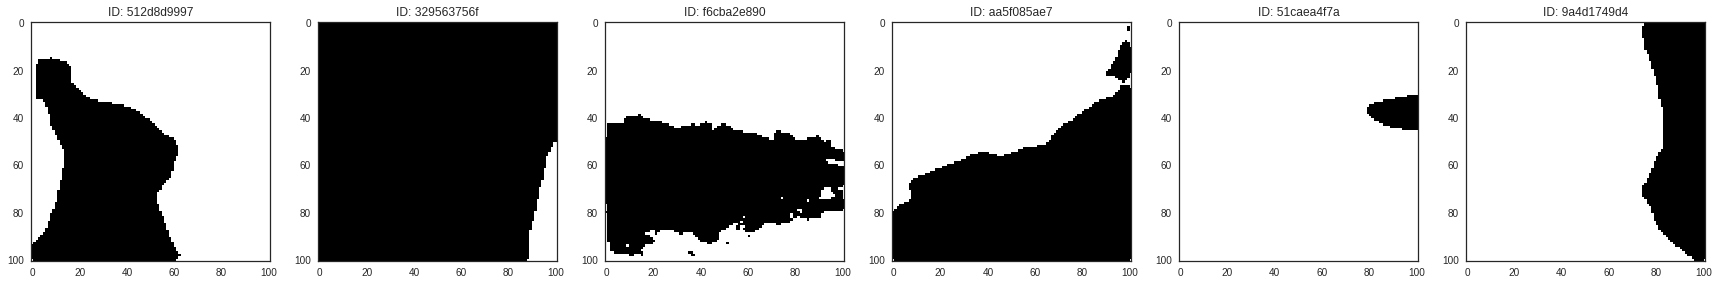

In [196]:
"""
reading and decoding the submission 

"""
#df = pd.read_csv('~/Downloads/results/submission_equalizer.csv')
df = pd.read_csv('submission_batch_64_BN_cleaned.csv')
i = 0
j = 0
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..
# Visualizing the predicted outputs
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])
        plt.subplot(1,6,j+1)
        plt.imshow(decoded_mask)
        plt.title('ID: '+df.loc[i,'id'])
        j = j + 1
        if j>5:
            break
    i = i + 1

In [0]:
test_path = './test/images/'

In [1]:
"""
visualizing the effect of applying CRF

"""
nImgs = 3
i = np.random.randint(1000)
j = 1
plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.2,hspace=0.1)  #adjust this to change vertical and horiz. spacings..
while True:
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(test_path+df.loc[i,'id']+'.png')
        #Applying CRF on FCN-16 annotated image
        crf_output = crf(orig_img,decoded_mask)
        plt.subplot(nImgs,4,4*j-3)
        plt.imshow(orig_img)
        plt.title('Original image')
        plt.subplot(nImgs,4,4*j-2)
        #plt.imshow(decoded_mask) 
        plt.imshow(np.fliplr(np.rot90(decoded_mask,k=3)))

        plt.title('Original Mask')
        plt.subplot(nImgs,4,4*j-1)
        #plt.imshow(crf_output) 
        plt.imshow(np.fliplr(np.rot90(crf_output,k=3)))
        plt.title('Mask after CRF')
        if j == nImgs:
            break
        else:
            j = j + 1
    i = i + 1

NameError: ignored

In [0]:
"""
Applying CRF on the predicted mask 

"""
for i in range(df.shape[0]):
    if str(df.loc[i,'rle_mask'])!=str(np.nan):        
        decoded_mask = rle_decode(df.loc[i,'rle_mask'])        
        orig_img = imread(test_path+df.loc[i,'id']+'.png')        
        crf_output = crf(orig_img,decoded_mask)
        df.loc[i,'rle_mask'] = rle_encode(crf_output)

In [0]:
df.to_csv('crf_correction_submission_batch_64_BN_cleaned.csv',index=False)

In [201]:
!kaggle competitions submit -c tgs-salt-identification-challenge -f crf_correction_submission_batch_64_BN_cleaned.csv -m "BN + reg + batch 64"

Successfully submitted to TGS Salt Identification Challenge

In [0]:
from google.colab import files
files.download('crf_correction_submission_batch_64_BN_cleaned.csv')